# OptOut: Construct Pre-1978 Employment Sequences 

Using raw work history varaibles

In [70]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [7]:
def diff_month(d1, d2):
    """
    Return the number of months between the two dates
    """
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Find subsample with missing pre-1978 sequences

In [2]:
# read existing monthly sequences
monthly_df = pd.read_csv("../data/monthly_df.csv")
monthly_df.head()

,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month207,month208,month209,month210,month211,month212,month213,month214,month215,month216
0,2,1993,4,5,1,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
1,3,1981,7,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
2,4,1980,9,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,0,0,0
3,8,1976,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
4,16,1990,3,1,1,5,5,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [11]:
pre1978_df = monthly_df[monthly_df.start_y<1978]
print pre1978_df.shape
pre1978_df.head(10) # pre-1978 monthly statuses are either 0 (missing) or 4 (nonemployed)

(481, 219)


,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month207,month208,month209,month210,month211,month212,month213,month214,month215,month216
3,8,1976,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
20,86,1977,12,4,4,4,4,4,4,4,...,1,1,1,1,1,4,1,1,1,1
62,204,1975,8,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
64,208,1975,9,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,0,0,0
66,224,1975,1,4,4,4,4,4,4,4,...,3,3,3,3,4,3,3,3,3,3
67,227,1975,10,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
76,244,1975,8,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
90,285,1977,11,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
117,382,1976,5,0,0,0,0,0,0,0,...,4,4,4,4,4,4,1,1,1,1
123,397,1976,2,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [13]:
def get_num_missing(row):
    """
    Return how many months pre-1978 have missing status 0
    """
    
    # find number of months between the start of sequence and 1978/1/1
    l = diff_month(datetime(1978, 1, 1), datetime(int(row['start_y']), int(row['start_m']), 1))
    
    # the months from 1 to l are the pre-1978 months
    is_missing = [row['month%s'%i]==0 for i in range(1, l+1)]
    return sum(is_missing)
    
pre1978_df['num_missing'] = pre1978_df.apply(get_num_missing, axis=1)
pre1978_df.num_missing.value_counts()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0     363
29      6
16      5
32      5
14      5
1       4
25      4
24      4
6       4
23      4
36      3
21      3
19      3
15      3
42      3
12      3
10      3
9       3
5       3
3       3
26      3
18      2
7       2
4       2
28      2
30      2
60      2
33      2
34      2
35      2
37      2
54      2
38      2
40      2
47      1
2       1
59      1
52      1
51      1
50      1
8       1
43      1
46      1
45      1
44      1
65      1
41      1
20      1
22      1
31      1
27      1
79      1
Name: num_missing, dtype: int64

In [14]:
# only need to consider respondents with positive number of missing months pre-1978
# 118 respondents only
pre1978_df = pre1978_df[pre1978_df.num_missing>0]
print pre1978_df.shape
pre1978_df.head()

(118, 220)


,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month208,month209,month210,month211,month212,month213,month214,month215,month216,num_missing
76,244,1975,8,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,29
117,382,1976,5,0,0,0,0,0,0,0,...,4,4,4,4,4,1,1,1,1,20
156,491,1974,2,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,47
202,627,1976,9,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,16
294,932,1977,9,0,0,0,0,3,3,3,...,1,1,1,1,1,1,1,1,1,4


# Read work history raw variables

In [5]:
df79 = pd.read_csv('../data/work_history79.csv')
df79.head()

,caseid_1979,employer_startdate_01_m_1979,employer_startdate_01_d_1979,employer_startdate_01_y_1979,employer_startdate_02_m_1979,employer_startdate_02_d_1979,employer_startdate_02_y_1979,employer_startdate_03_m_1979,employer_startdate_03_d_1979,employer_startdate_03_y_1979,...,nonemployed_prior_int_01_1979,nonemployed_prior_int_02_1979,nonemployed_prior_int_03_1979,nonemployed_prior_int_04_1979,nonemployed_prior_int_05_1979,nonemployed_since_int_01_1979,nonemployed_since_int_02_1979,nonemployed_since_int_03_1979,nonemployed_since_int_04_1979,nonemployed_since_int_05_1979
0,1,5,22,78,9,20,75,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
1,2,5,8,78,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,0,-4,-4,-4,-4
2,3,9,11,78,5,15,78,1,30,78,...,-4,-4,-4,-4,-4,0,0,0,-4,-4
3,4,-4,-4,-4,-4,-4,-4,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,5,2,1,78,6,5,78,-4,-4,-4,...,-4,-4,-4,-4,-4,1,0,-4,-4,-4


In [16]:
pre1978_df['caseid_1979'] = pre1978_df.id
pre1978_df = pre1978_df.merge(df79, on='caseid_1979')
pre1978_df.employer_startdate_01_y_1979.value_counts()

-4     44
 77    23
 78    18
 79    16
 76    12
 74     2
 75     1
 72     1
 69     1
Name: employer_startdate_01_y_1979, dtype: int64

<font color='red'>**However, having valid skip in first job does not mean having valid skip in all jobs.**</font>

In [17]:
# for those with valid skip in first job, do they have valid skip in all jobs? NO
# show distribution of start year for each job

sub_df = pre1978_df[pre1978_df.employer_startdate_01_y_1979==-4]
for i in range(1, 6):
    print sub_df['employer_startdate_%02d_y_1979'%i].value_counts()
    print

-4    44
Name: employer_startdate_01_y_1979, dtype: int64

77    23
78    13
79     2
76     2
75     2
74     2
Name: employer_startdate_02_y_1979, dtype: int64

-4     26
 77    10
 78     4
 79     2
 76     2
Name: employer_startdate_03_y_1979, dtype: int64

-4     41
 77     2
 78     1
Name: employer_startdate_04_y_1979, dtype: int64

-4     43
 78     1
Name: employer_startdate_05_y_1979, dtype: int64



# Update monthly work hours pre-1978

### First, explore job dates

* Missing months: 3 respondents had missing job start month, but the start year is before the sequence start year, so the missing does not matter

* Missing day: the above 3 respondents + 23 more cases. assume job started on the 15th. 1 person has a missing stop day, assume the 15th

In [64]:
pre1978_df.employer_startdate_01_y_1979.value_counts()

-4     44
 77    23
 78    18
 79    16
 76    12
 74     2
 75     1
 72     1
 69     1
Name: employer_startdate_01_y_1979, dtype: int64

In [116]:
missing = []

def find_job_dates(row):
    """Explore job dates and missingness"""
    
    job_dates = [] # (start_y, start_m, stop_y, stop_m)
    
    for i in range(1, 6): # iterate through jobs
        start_y = row['employer_startdate_%02d_y_1979'%i]
        start_m = row['employer_startdate_%02d_m_1979'%i]
        start_d = row['employer_startdate_%02d_d_1979'%i]
        stop_y = row['employer_stopdate_%02d_y_1979'%i]
        stop_m = row['employer_stopdate_%02d_m_1979'%i]
        stop_d = row['employer_stopdate_%02d_d_1979'%i]
        
        if start_y > 0 and start_m > 0 and start_d > 0:
            
            # job still current at 1979 interview, okay to assign 1979/1 as stop month 
            # for our purpose of reconstructing pre-1978 sequence
            if stop_y == -4 and stop_m == -4 and stop_d == -4: 
                job_dates.append((start_y, start_m, start_d, 1979, 1, 1))
                
            elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                job_dates.append((start_y, start_m, start_d, stop_y, stop_m, stop_d))
                
            else:
                print 'missing job stop date:', row['caseid_1979'], 'seq start at:', (row['start_y'], row['start_m']), 'job dates:', (start_y, start_m, start_d, stop_y, stop_m, stop_d)
                missing.append('missing stop date')
                
        elif start_y == -4 and start_m == -4 and start_d == -4:
            pass
        
        else:
            print 'missing job start date:', row['caseid_1979'], 'seq start at:', (row['start_y'], row['start_m']), 'job dates:', (start_y, start_m, start_d, stop_y, stop_m, stop_d)
            job_dates.append((start_y, start_m, start_d, stop_y, stop_m, stop_d))
            if start_m < 0:
                missing.append('missing start date - month')
            if start_d < 0:
                missing.append('missing start date - day')
            
    print job_dates
    
res = pre1978_df.apply(find_job_dates, axis=1)

missing job start date: 244 seq start at: (1975, 8) job dates: (77, 11, -2, -4, -4, -4)
missing job start date: 244 seq start at: (1975, 8) job dates: (78, 2, -2, -4, -4, -4)
missing job start date: 244 seq start at: (1975, 8) job dates: (78, 2, -2, -4, -4, -4)
missing job start date: 244 seq start at: (1975, 8) job dates: (77, 2, -2, 79, 1, -2)
[(77, 11, -2, -4, -4, -4), (78, 2, -2, -4, -4, -4), (78, 2, -2, -4, -4, -4), (77, 2, -2, 79, 1, -2)]
missing job start date: 382 seq start at: (1976, 5) job dates: (77, 10, -2, 78, 2, -2)
[(78, 6, 15, 78, 9, 10), (77, 10, -2, 78, 2, -2)]
[(78, 10, 29, 1979, 1, 1), (78, 5, 10, 78, 10, 7), (72, 2, 6, 78, 4, 1), (78, 1, 4, 78, 1, 31)]
[(74, 6, 6, 1979, 1, 1)]
[(77, 9, 25, 78, 10, 1)]
[(76, 9, 7, 1979, 1, 1)]
[(77, 10, 23, 78, 1, 2)]
missing job start date: 1111 seq start at: (1976, 2) job dates: (76, 4, -2, 79, 2, 9)
[(76, 4, -2, 79, 2, 9)]
[(77, 2, 9, 1979, 1, 1)]
[(77, 3, 15, 1979, 1, 1)]
missing job start date: 1225 seq start at: (1973, 10) job

In [117]:
missing.count('missing start date - month'), missing.count('missing start date - day'), missing.count('missing stop date')

(3, 26, 1)

### Look into 1980 work history raw variables and see if any respondent reported pre-1978 jobs in 1980 survey

No, all jobs reported in 1980 survey started in 1979 or 1980 (possibly continuing from the jobs reported in 1979, but for our purpose of reconstructing pre-1978 sequences, we don't need the jobs reported in 1980 survey).

In [20]:
df80 = pd.read_csv('../data/work_history80.csv')
df80.head()

,caseid_1979,emp1previd_1980,same_employer_1_1980,employer_startdate_01_m_1980,employer_startdate_01_d_1980,employer_startdate_01_y_1980,working_at_job_01_1980,employer_stopdate_01_m_1980,employer_stopdate_01_d_1980,employer_stopdate_01_y_1980,...,qes_2e_05_1980,employer_startdate_05_m_1980,employer_startdate_05_d_1980,employer_startdate_05_y_1980,nonemployed_prior_int_05_1980,working_at_job_05_1980,employer_stopdate_05_m_1980,employer_stopdate_05_d_1980,employer_stopdate_05_y_1980,hours_per_week_job_05_1980
0,1,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
1,2,1,-4,2,28,79,1,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,3,-4,-4,4,1,80,1,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,4,-5,-5,-5,-5,-5,-5,-5,-5,-5,...,-5,-5,-5,-5,-5,-5,-5,-5,-5,-5
4,5,1,-4,4,19,79,1,-4,-4,-4,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [21]:
pre1978_df = pre1978_df.merge(df80, on='caseid_1979')

In [52]:
start_years = []

def find_job_dates_v2(row):
    """Check job dates reported in 1980 survey"""
    
    job_dates = []
    for i in range(1, 6):
        start_y = row['employer_startdate_%02d_y_1980'%i]
        start_m = row['employer_startdate_%02d_m_1980'%i]
#         stop_y = row['employer_stopdate_%02d_y_1980'%i]
#         stop_m = row['employer_stopdate_%02d_m_1980'%i]

        if start_y > 0 and start_m > 0:
            start_years.append(start_y)
            job_dates.append((start_y, start_m))
        elif start_y == -4 and start_m == -4:
            pass
        else:
            print 'missing job start date:', row['caseid_1979'], 'seq start at:', (row['start_y'], row['start_m']), 'job dates:', (start_y, start_m)
            job_dates.append((start_y, start_m))
            
    print job_dates
    
res = pre1978_df.apply(find_job_dates_v2, axis=1)

[(79, 3)]
[(79, 3)]
[(79, 2)]
[(79, 4)]
[(79, 3)]
[(79, 2)]
[(79, 8)]
[(79, 6), (79, 4)]
[(79, 3)]
[(79, 2)]
[(79, 6)]
[]
[(79, 3)]
[(79, 12), (79, 8), (79, 4), (79, 3)]
[(79, 3), (79, 9)]
[]
[(79, 3)]
[(79, 2)]
[(79, 7), (79, 3)]
[(79, 2)]
[(79, 3)]
missing job start date: 2193 seq start at: (1977, 7) job dates: (-5, -5)
missing job start date: 2193 seq start at: (1977, 7) job dates: (-5, -5)
missing job start date: 2193 seq start at: (1977, 7) job dates: (-5, -5)
missing job start date: 2193 seq start at: (1977, 7) job dates: (-5, -5)
missing job start date: 2193 seq start at: (1977, 7) job dates: (-5, -5)
[(-5, -5), (-5, -5), (-5, -5), (-5, -5), (-5, -5)]
[(79, 10), (79, 6)]
[(79, 3)]
[(80, 1), (79, 4)]
[(79, 2)]
[(79, 9), (79, 2)]
[(79, 6), (79, 2)]
[]
[(80, 2), (79, 3)]
[(79, 7)]
[(79, 3)]
[(79, 10), (79, 5), (79, 3)]
[(79, 8), (79, 4)]
[(79, 2)]
[(79, 10), (79, 3)]
missing job start date: 4179 seq start at: (1975, 12) job dates: (-5, -5)
missing job start date: 4179 seq start at:

In [53]:
set(start_years)

{79, 80}

### Now, update monthly work hours - start with extending crosswalk to pre-1978 years

In [67]:
# read the original NLSY79 crosswalk
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [75]:
# column names
weekdf.columns

Index([u'Week Start:\nMonth', u'Week Start: \nDay', u'Week Start: \nYear',
       u'Calendar Year \nWeek Number ', u'Continuous \nWeek Number'],
      dtype='object')

In [74]:
# find the earliest date we need to account for - 1971/6/1

earliest = datetime(1978, 1, 1)

for i, row in pre1978_df.iterrows():
    dt = datetime(int(row['start_y']), int(row['start_m']), 1)
    if dt < earliest:
        earliest = dt
        
print earliest

1971-06-01 00:00:00


In [76]:
# construct new crosswalk pre-1978, use negative week number

earliest = datetime(1971, 6, 1)

data = defaultdict(list)

i = -1
week_start = datetime(1978, 1, 1)

while week_start > earliest:

    prev_week_start = week_start - timedelta(days=7) # count back 7 days
    
    data['Week Start:\nMonth'].append(prev_week_start.month)
    data['Week Start: \nDay'].append(prev_week_start.day)
    data['Week Start: \nYear'].append(prev_week_start.year)
    
    data['Calendar Year \nWeek Number '].append(None) # leave not the Calendar Year Week Number column
    data['Continuous \nWeek Number'].append(i)
    
    i -= 1 # update index
    week_start = prev_week_start # update week_start
    
    
weekdf_pre1978 = pd.DataFrame(data, columns=weekdf.columns)
weekdf_pre1978.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,12,25,1977,None,-1
1,12,18,1977,None,-2
2,12,11,1977,None,-3
3,12,4,1977,None,-4
4,11,27,1977,None,-5


In [77]:
weekdf_pre1978.tail()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
339,6,27,1971,None,-340
340,6,20,1971,None,-341
341,6,13,1971,None,-342
342,6,6,1971,None,-343
343,5,30,1971,None,-344


In [90]:
# reverse row orders - put the earliest week as the first row
weekdf_pre1978 = weekdf_pre1978.reindex(index=weekdf_pre1978.index[::-1])
weekdf_pre1978.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
343,5,30,1971,None,-344
342,6,6,1971,None,-343
341,6,13,1971,None,-342
340,6,20,1971,None,-341
339,6,27,1971,None,-340


In [92]:
# row bind with our original weekdf
print weekdf.shape
weekdf = pd.concat([weekdf_pre1978, weekdf])
print weekdf.shape
weekdf.head()

(1879, 5)
(2223, 5)


,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
343,5,30,1971,NaN,-344
342,6,6,1971,NaN,-343
341,6,13,1971,NaN,-342
340,6,20,1971,NaN,-341
339,6,27,1971,NaN,-340


In [103]:
# test our new crosswalk

def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = df[(df['Week Start:\nMonth']==month)&(df['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])
    

def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = df[df['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])


print get_week_num(1976, 2, 'first')
print get_year_month(-100)
print get_week_num(1976, 2, 'last')
print get_year_month(-96)

-100
(1976, 2)
-96
(1976, 2)


### Create monthly statuses from weekly statuses

In [156]:
def _is_in_job_period(date, job_date):
    """
    Return True if the given date is within the job duration
    """
    
    
    return date >= datetime(start_y, start_m, 1) and date <= datetime(stop_y, stop_m, 1)


def is_in_job_period(week_num, job_date):
    """
    Given a week number and the start/stop y/m/d of a job, 
    return True if the given week overlaps the job duration
    """
    i, start_y, start_m, start_d, stop_y, stop_m, stop_d = job_date
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==week_num].iloc[0]
    week_start = datetime(int(the_week['Week Start: \nYear']), int(the_week['Week Start:\nMonth']), int(the_week['Week Start: \nDay']))
    week_stop = week_start + timedelta(days=6)
    
    if week_stop < datetime(start_y, start_m, 1): # week ended before job started
        return False
    elif week_start > datetime(stop_y, stop_m, 1): # week started after job ended
        return False
    else: # there is at leats one day overlap
        return True
    
    
# test it
print is_in_job_period(week_num=-252, job_date=(1, 1975, 9, 20, 1979, 1, 1)) # week -252 starts on 1973/3/4
print is_in_job_period(week_num=-17, job_date=(1, 1975, 9, 20, 1979, 1, 1)) # week -17 starts on 1977/9/4
print is_in_job_period(week_num=200, job_date=(1, 1975, 9, 20, 1979, 1, 1)) # week 200 starts on 1981/10/25

False
True
False


In [157]:
def get_weekly_status(week_num, job_dates):
    """
    Given a week number, find all jobs that overlap with the week.
    
    If no overlap, weekly status is 4 (nonemployed)
    
    If there is overlap(s), add up hours per week from all overlapped jobs. 
    - If hours >= 35, weekly status is 1 (full-time)
    - If hours is between (0, 35), weekly status is 3 (part-time)
    - If hours is missing, weekly status is 2 (working with missing hours)
    """
    
    overlap_jobs = [job_date for job_date in job_dates if is_in_job_period(week_num, job_date)]
        
    if len(overlap_jobs) == 0: # this month does not overlap with any job
        return 4 # nonemployed

    else:    
        overlap_job_nums = map(itemgetter(0), overlap_jobs)
        hours = [row['hours_per_week_job_%02d_1979'%j] for j in overlap_job_nums]
        missing_hours = [h < 0 for h in hours]

        if sum(missing_hours) > 0: # has missing hours
            print 'working with missing hours:', row['caseid_1979'], 'week #:', week_num
            return 2 # working with missing hours
        else:
            if sum(hours) >= 35:
                return 1 # full-time
            else:
                return 3 # part-time


            
def find_modal(l):
    """
    Given a list l, return the most common element in the list. 
    if there is a tie, return all elements.
    """
    
    #first, count frequency of each unique item in the list
    counter = defaultdict(int)
    for item in l:
        counter[item] += 1

    #rank items from most frequent to least frequent
    popular_items = sorted(counter, key=counter.get, reverse = True)
    
    most_common = [popular_items[0]]
    
    for other in popular_items[1:]:
        if counter[other] < counter[most_common[0]]:
            break
        elif counter[other] == counter[most_common[0]]: #find an equally frequent item
            most_common.append(other)
        else:
            print 'impossible'

    return most_common            
            
  

In [180]:
# set random seed
import random
random.seed(7222014)


to_update = {}

    
# update monthly statuses
for i, row in pre1978_df.iterrows():
    
    ###### first, get all job dataes ######
    
    job_dates = [] # (start_y, start_m, stop_y, stop_m)
    for i in range(1, 6):
        start_y = row['employer_startdate_%02d_y_1979'%i]
        start_m = row['employer_startdate_%02d_m_1979'%i]
        start_d = row['employer_startdate_%02d_d_1979'%i]
        
        stop_y = row['employer_stopdate_%02d_y_1979'%i]
        stop_m = row['employer_stopdate_%02d_m_1979'%i]
        stop_d = row['employer_stopdate_%02d_d_1979'%i]
        
        # edit years - years are often reported in two digit format
        if start_y < 1900 and start_y > 0:
            start_y += 1900
        if stop_y < 1900 and stop_y > 0:
            stop_y += 1900
        
        if start_m < 0 and start_m != -4:
            # print 'missing job start month:', row['caseid_1979']

            # job start year was before sequence start year, so the missing does not matter
            # assign sequence start year as job start year - sufficient for our purpose of reconstructing pre-1978 sequence
            start_y = row['start_y']
            start_m = row['start_m']
            
        if start_d < 0 and start_d != -4: # assume job started on the 15th
            # print 'missing job start day:', row['caseid_1979']
            start_d = 15
            
        if stop_d < 0 and stop_d != -4: # assume job started on the 15th
            # print 'missing job stop day:', row['caseid_1979']
            stop_d = 15            
        
        if start_y > 0 and start_m > 0 and start_d > 0:
            if stop_y == -4 and stop_m == -4 and stop_d == -4: # job still current at 1979 interview
                job_dates.append((i, start_y, start_m, start_d, 1979, 1, 1))
            elif stop_y > 0 and stop_m > 0 and stop_d > 0:
                job_dates.append((i, start_y, start_m, start_d, stop_y, stop_m, stop_d))
            else:
                raise Exception, 'should be no longer be any missing stop date'
        elif start_y == -4 and start_m == -4 and start_d == -4: # valid skip
            pass 
        else:
            raise Exception, 'should be no longer be any missing start date'
      
    
    ###### update monthly statuses ######
    
    # sequence start month 
    y = int(row['start_y'])
    m = int(row['start_m'])
    
    # number of months between sequence start month and 1978/1/1
    l = diff_month(datetime(1978, 1, 1), datetime(y, m, 1))
    
    # the pre-1978 months are month 1 to month l. iterate through them
    for i in range(1, l+1):
        weeks = range(get_week_num(y, m, 'first'), get_week_num(y, m, 'last')+1)
        wk_statuses = [get_weekly_status(w, job_dates) for w in weeks]
        
        #find unique items in the given month 
        distinct = list(set(wk_statuses))
        distinct.sort()

        if len(distinct) == 1:
            row['month%s'%i] = distinct[0]
            to_update[(row['caseid_1979'], i)] = row['month%s'%i]

        elif len(distinct) >= 2:
            print 'there are multiple statuses:', row['caseid_1979'], wk_statuses
            modal = find_modal(wk_statuses)
            if len(modal) == 1:
                row['month%s'%i] = modal[0]
                to_update[(row['caseid_1979'], i)] = row['month%s'%i]
            else:
                print 'there is a tie:', row['caseid_1979']
                row['month%s'%i] = random.choice(modal)
                to_update[(row['caseid_1979'], i)] = row['month%s'%i]
 

        # go to next month
        if m == 12:
            m = 1
            y += 1
        else:
            m += 1

there are multiple statuses: 244 [4, 4, 4, 4, 3]
there are multiple statuses: 382 [4, 4, 4, 3]
there are multiple statuses: 995 [4, 4, 4, 4, 1]
there are multiple statuses: 1057 [4, 4, 4, 1]
there are multiple statuses: 1111 [4, 4, 4, 1]
there are multiple statuses: 1189 [4, 4, 4, 4, 3]
there are multiple statuses: 1209 [4, 4, 4, 1]
there are multiple statuses: 1225 [4, 4, 4, 1]
there are multiple statuses: 1376 [4, 4, 4, 1]
there are multiple statuses: 1517 [4, 4, 4, 4, 3]
there are multiple statuses: 1552 [4, 4, 4, 1]
there are multiple statuses: 1559 [4, 4, 4, 4, 1]
there are multiple statuses: 1600 [4, 4, 4, 4, 1]
there are multiple statuses: 1760 [4, 4, 4, 3]
there are multiple statuses: 1824 [4, 4, 4, 1]
there are multiple statuses: 2036 [4, 4, 4, 1]
there are multiple statuses: 2105 [4, 4, 4, 1]
there are multiple statuses: 2196 [4, 4, 4, 1]
there are multiple statuses: 2528 [4, 4, 4, 3]
there are multiple statuses: 2746 [4, 4, 4, 1]
there are multiple statuses: 3021 [4, 4, 4, 4

In [181]:
len(to_update)

2962

In [182]:
# get number of missing months after we've updated pre-1978 months
pre1978_df['num_missing_after'] = pre1978_df.apply(get_num_missing, axis=1)
pre1978_df.num_missing_after.value_counts()

0    118
Name: num_missing_after, dtype: int64

**<font color='red'>No more missing, but we have some months (shown above) working with missing hours (status 2)</font>**

## Update within-job gaps

Here are the variables I'm looking at:

* Variable: **ANY PERIODS NOT EMPLOYED  PRIOR TO LAST INT? (DATE IS < LAST INT) JOB #01**

ORIGINAL QUESTION NAME: S10Q08B1

BEFORE JAN. 1, 1978, WERE THERE ANY PERIODS OF ONE MONTH OR MORE DURING WHICH 
YOU WERE NOT WORKING FOR (EMPLOYER), NOT COUNTING PAID VACATION OR PAID SICK 
LEAVE?

UNIVERSE: R has employer; job began before DLI



* Variable: **ANY PERIODS NOT EMPLOYED  SINCE LAST INT? JOB #01**

ORIGINAL QUESTION NAME: S10Q09A

FOR ONE REASON OR ANOTHER, PEOPLE OFTEN DO NOT WORK FOR A WEEK, A MONTH, OR EVEN
LONGER. FOR EXAMPLE, STRIKES, LAYOFFS, AND EXTENDED ILLNESSES CAN CAUSE PEOPLE 
TO MISS WORK FOR A WEEK OR LONGER.

BETWEEN (DATE STARTED/JAN. 1, 1978) AND (DATE JOB ENDED/NOW), WERE THERE ANY 
PERIODS OF A FULL WEEK OR MORE DURING WHICH YOU DID NOT WORK FOR THIS EMPLOYER, 
NOT COUNTING PAID VACATIONS AND PAID SICK LEAVE?

UNIVERSE: R has employer

In [46]:
# any period nonemployed prior to last interview?
for i in range(1, 6):
    print pre1978_df['nonemployed_prior_int_%02d_1979'%i].value_counts()
    print 

-4    80
 0    27
 1    11
Name: nonemployed_prior_int_01_1979, dtype: int64

-4    71
 0    35
 1    12
Name: nonemployed_prior_int_02_1979, dtype: int64

-4    97
 0    15
 1     6
Name: nonemployed_prior_int_03_1979, dtype: int64

-4    115
 0      3
Name: nonemployed_prior_int_04_1979, dtype: int64

-4    118
Name: nonemployed_prior_int_05_1979, dtype: int64



In [47]:
# any period nonemployed since last interview?
for i in range(1, 6):
    print pre1978_df['nonemployed_since_int_%02d_1979'%i].value_counts()
    print 

 0    65
-4    43
 1    10
Name: nonemployed_since_int_01_1979, dtype: int64

 0    58
-4    44
 1    16
Name: nonemployed_since_int_02_1979, dtype: int64

-4    86
 0    25
 1     5
-3     2
Name: nonemployed_since_int_03_1979, dtype: int64

-4    111
 0      5
 1      2
Name: nonemployed_since_int_04_1979, dtype: int64

-4    117
 0      1
Name: nonemployed_since_int_05_1979, dtype: int64



In [161]:
# how many respondents had nonemployed period?
# I THINK WE ONLY CARE ABOUT NONEMPLOYED PERIOR PRIOR TO INTERVIEW

def has_nonemployed_period(row):
    """
    Return True if respondent reported any period nonemployed
    """
    
    vals = [row['nonemployed_prior_int_%02d_1979'%i] for i in range(1, 6)]
    # vals += [row['nonemployed_since_int_%02d_1979'%i] for i in range(1, 6)]
    
    return 1 in vals

res = pre1978_df.apply(has_nonemployed_period, axis=1)
res.value_counts()

False    89
True     29
dtype: int64

**Decision rules:** If has nonemployed period prior to interview and working up to 1 month before the birth and 4 months after the birth, assign these months to status 5 - maternity leave

In [131]:
# read dataframe with child births
analytic_df = pd.read_csv('../data/analytic_df.csv')
analytic_df.head()

,caseid_1979,sample_id_1979,sample_race_1979,sample_sex_1979,c1dob_m_xrnd,c1dob_y_xrnd,c2dob_m_xrnd,c2dob_y_xrnd,c3dob_m_xrnd,c3dob_y_xrnd,...,y_dob,m_dob,y_age35,y_deceased,last_yr,attr_before35,deceased_before35,y_child18,deceased_child18,attr_child18
0,2,5,3,2,3,1993,11,1994,-4,-4,...,1959,1,1994,NaN,2014,False,False,2011,False,False
1,3,5,3,2,6,1981,10,1983,4,1986,...,1961,8,1996,NaN,2014,False,False,1999,False,False
2,4,5,3,2,8,1980,3,1997,-4,-4,...,1962,8,1997,NaN,1998,False,False,1998,False,False
3,8,6,3,2,3,1976,5,1979,9,1982,...,1958,7,1993,NaN,2014,False,False,1994,False,False
4,16,5,3,2,2,1990,8,1993,9,1996,...,1958,10,1993,NaN,2014,False,False,2008,False,False


In [132]:
# merge with childbirth dates
pre1978_df = pre1978_df.merge(analytic_df, on='caseid_1979')

In [190]:
def is_close_to_birth(y, m, row):
    """
    Return True if the given month is up to 1 month before any birth and 4 months after any birth.
    """
    
    for i in range(1, 12):
        if row['c%idob_y_xrnd'%i] > 0: # there is a birth
            
            if row['c%idob_m_xrnd'%i] > 0:
                d = diff_month(datetime(int(row['c%idob_y_xrnd'%i]), int(row['c%idob_m_xrnd'%i]), 1), datetime(y, m, 1))
                return (d >= -4 and d <= 1)
            
            else: # if birth month missing, assume June
                d = diff_month(datetime(int(row['c%idob_y_xrnd'%i]), 6, 1), datetime(y, m, 1))
                return (d >= -4 and d <= 1)

            
to_update_ml = {}
    
for i, row in pre1978_df.iterrows():
    
    if has_nonemployed_period(row): # reported a nonemployed period
        
        # sequence start month 
        y = int(row['start_y'])
        m = int(row['start_m'])

        # number of months between sequence start month and 1978/1/1
        l = diff_month(datetime(1978, 1, 1), datetime(y, m, 1))

        # the pre-1978 months are month 1 to month l. iterate through them
        for i in range(1, l+1):   
            if row['month%s'%i] in [1, 2, 3] and is_close_to_birth(y, m, row):
                print 'changed to maternity leave:', row['caseid_1979'], y, m
                row['month%s'%i] = 5 # FOR SOME REASON, THE DATAFRAME ISN'T UPDATED  
                to_update_ml[(row['caseid_1979'], i)] = 5
                
                
            # go to next month
            if m == 12:
                m = 1
                y += 1
            else:
                m += 1        

changed to maternity leave: 627 1976 9
changed to maternity leave: 627 1976 10
changed to maternity leave: 627 1976 11
changed to maternity leave: 627 1976 12
changed to maternity leave: 1495 1977 11
changed to maternity leave: 1495 1977 12
changed to maternity leave: 2193 1977 7
changed to maternity leave: 2193 1977 8
changed to maternity leave: 2193 1977 9
changed to maternity leave: 2193 1977 10
changed to maternity leave: 3769 1977 3
changed to maternity leave: 3769 1977 4
changed to maternity leave: 3769 1977 5
changed to maternity leave: 3769 1977 6
changed to maternity leave: 3779 1977 1
changed to maternity leave: 3779 1977 2
changed to maternity leave: 3779 1977 3
changed to maternity leave: 3779 1977 4
changed to maternity leave: 4105 1977 12
changed to maternity leave: 4400 1977 10
changed to maternity leave: 4400 1977 11
changed to maternity leave: 4400 1977 12
changed to maternity leave: 5855 1977 2
changed to maternity leave: 5919 1977 3
changed to maternity leave: 5919 1

In [192]:
len(to_update_ml)

36

# Update pre-1978 statuses in our original monthly_df

In [193]:
monthly_df.shape

(3434, 219)

In [196]:
def update(row, i):
    """
    Given a row of respondent data and a month number i, 
    return the updated month status
    """
    
    if row['start_y'] < 1978 and get_num_missing(row) > 0:
        if to_update_ml.has_key((row['id'], i)):
            print 'changed to ml:', row['id'], i
            return 5
        print 'changed:', row['id'], i
        return pre1978_df[pre1978_df.caseid_1979==row['id']].iloc[0]['month%s'%i]
    else:
        return row['month%s'%i]
    

for i in range(1, 217):
    monthly_df['month%s'%i] = monthly_df.apply(lambda row: update(row, i), axis=1)

changed: 244 1
changed: 382 1
changed: 491 1
changed to ml: 627 1
changed: 932 1
changed: 995 1
changed: 1057 1
changed: 1111 1
changed: 1189 1
changed: 1209 1
changed: 1225 1
changed: 1376 1
changed to ml: 1495 1
changed: 1517 1
changed: 1552 1
changed: 1559 1
changed: 1600 1
changed: 1760 1
changed: 1824 1
changed: 2036 1
changed: 2105 1
changed to ml: 2193 1
changed: 2196 1
changed: 2311 1
changed: 2528 1
changed: 2746 1
changed: 3021 1
changed: 3041 1
changed: 3316 1
changed: 3705 1
changed to ml: 3769 1
changed to ml: 3779 1
changed: 3927 1
changed: 3992 1
changed to ml: 4105 1
changed: 4136 1
changed: 4179 1
changed: 4268 1
changed to ml: 4400 1
changed: 4450 1
changed: 4483 1
changed: 5064 1
changed: 5121 1
changed: 5294 1
changed: 5311 1
changed: 5339 1
changed: 5425 1
changed: 5555 1
changed: 5557 1
changed: 5615 1
changed: 5689 1
changed: 5849 1
changed: 5855 1
changed: 5889 1
changed to ml: 5919 1
changed: 6024 1
changed: 6047 1
changed: 6078 1
changed to ml: 6177 1
changed:

### Check the distribution of the updated pre-1978 sequences

In [163]:
def get_num_months(row, status):
    """
    Count how many months pre-1978 has the given status per respondent
    """
    
    # number of months between sequence start month and 1978/1/1
    l = diff_month(datetime(1978, 1, 1), datetime(int(row['start_y']), int(row['start_m']), 1))
    
    has_status = [row['month%s'%i]==status for i in range(1, l+1)]
    return sum(has_status)

def get_total_months_pre1978(row):
    """
    Count how many months pre-1978
    """
    
    # number of months between sequence start month and 1978/1/1
    l = diff_month(datetime(1978, 1, 1), datetime(int(row['start_y']), int(row['start_m']), 1))
    return l


In [201]:
sample_pre1978 = pre1978_df.caseid_1979.values.tolist()
count_df = monthly_df[monthly_df.id.isin(sample_pre1978)]
print count_df.shape
count_df.head()

(118, 219)


,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month207,month208,month209,month210,month211,month212,month213,month214,month215,month216
76,244,1975,8,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
117,382,1976,5,4,4,4,4,4,4,4,...,4,4,4,4,4,4,1,1,1,1
156,491,1974,2,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
202,627,1976,9,5,5,5,5,1,1,1,...,4,4,4,4,4,4,4,4,4,4
294,932,1977,9,3,3,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1


In [202]:
count_df['total_months_pre1978'] = count_df.apply(get_total_months_pre1978, axis=1)
count_df['num_months_ft_pre1978'] = count_df.apply(lambda row: get_num_months(row, 1), axis=1)
count_df['num_months_miss_hours_pre1978'] = count_df.apply(lambda row: get_num_months(row, 2), axis=1)
count_df['num_months_pt_pre1978'] = count_df.apply(lambda row: get_num_months(row, 3), axis=1)
count_df['num_months_nonemployed_pre1978'] = count_df.apply(lambda row: get_num_months(row, 4), axis=1)
count_df['num_months_ml_pre1978'] = count_df.apply(lambda row: get_num_months(row, 5), axis=1) # maternity leave
count_df['num_months_miss_pre1978'] = count_df.apply(lambda row: get_num_months(row, 0), axis=1)
count_df.head()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/xzhuo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month214,month215,month216,total_months_pre1978,num_months_ft_pre1978,num_months_miss_hours_pre1978,num_months_pt_pre1978,num_months_nonemployed_pre1978,num_months_ml_pre1978,num_months_miss_pre1978
76,244,1975,8,4,4,4,4,4,4,4,...,1,1,1,29,0,0,11,18,0,0
117,382,1976,5,4,4,4,4,4,4,4,...,1,1,1,20,0,0,3,17,0,0
156,491,1974,2,1,1,1,1,1,1,1,...,1,1,1,47,47,0,0,0,0,0
202,627,1976,9,5,5,5,5,1,1,1,...,4,4,4,16,12,0,0,0,4,0
294,932,1977,9,3,3,3,3,3,3,3,...,1,1,1,4,0,0,4,0,0,0


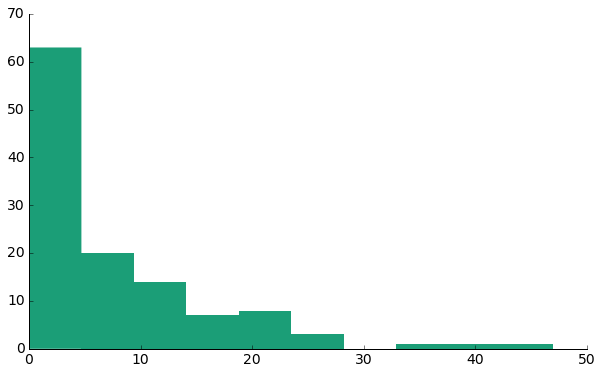

In [204]:
plt.hist(count_df.num_months_ft_pre1978)
remove_border()

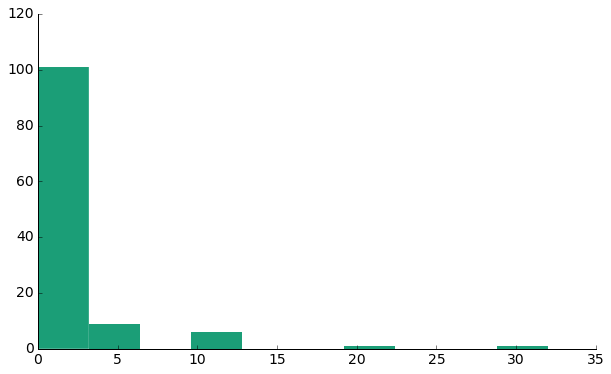

In [205]:
plt.hist(count_df.num_months_pt_pre1978)
remove_border()

In [206]:
count_df.num_months_miss_hours_pre1978.value_counts()

0     115
38      1
5       1
2       1
Name: num_months_miss_hours_pre1978, dtype: int64

In [207]:
count_df.num_months_ml_pre1978.value_counts()

0    105
4      6
1      4
3      2
2      1
Name: num_months_ml_pre1978, dtype: int64

In [208]:
count_df.num_months_miss_pre1978.value_counts()

0    118
Name: num_months_miss_pre1978, dtype: int64

In [ ]:
# export updated monthly_df
monthly_df.to_csv('../data/monthly_df_updated.csv', index=False)